In [1]:
import torch
import torch.nn as nn
import torchmetrics
from torch.utils.data import Dataset,  DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
test_labels = np.load("Test(Targets).npy")
test_labels = np.squeeze(test_labels, axis=2)
test_inputs = np.load("Test(Features).npy")
test_inputs = np.squeeze(test_inputs, axis=2)
val_features = np.load("Val(Features).npy")
val_features = np.squeeze(val_features, axis=2)
val_targets = np.load("Val(Targets).npy")
val_targets = np.squeeze(val_targets, axis=2)

In [3]:
if len(test_labels)==len(test_inputs):
    print(len(test_labels))
if len(val_features)==len(val_targets):
    print(len(val_features))

18
50


In [4]:
class dataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = torch.Tensor(inputs)
        self.labels = torch.Tensor(labels)
    def __getitem__(self, idx):
        inp = self.inputs[idx]
        label = self.labels[idx]
        return inp, label
    def __len__(self):
        length = len(self.labels)
        return length

In [5]:
test_dataloader = DataLoader(dataset(test_inputs, test_labels),
                             batch_size=18, 
                             shuffle=False
                            )
val_dataloader = DataLoader(dataset(val_features, val_targets),
                            batch_size=50,
                            shuffle=False
                           )

In [6]:
class LSTM(nn.Module):
    def __init__(self, n_layers, hidden_dim, l1, l2):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.l1 = l1
        self.l2 = l2
        self.fc1 = nn.Linear(self.hidden_dim, self.l1)
        self.fc2 = nn.Linear(self.l1, self.l2)
        self.fc3 = nn.Linear(self.l2, 1)
        self.recurrent_layers = nn.LSTM(hidden_size=self.hidden_dim,
                                        num_layers=self.n_layers,
                                        batch_first=True,
                                        input_size=5
                                        )
                                        
    def forward(self, inp):
        LSTMpred = self.recurrent_layers(inp)
        output, hidden_cell_states = LSTMpred
        pred = self.fc1(output)
        pred = self.fc2(nn.functional.softmax(pred))
        pred = self.fc3(nn.functional.softmax(pred))
        return pred
    

In [7]:
def test(dataloader):
    metric = torchmetrics.MeanAbsolutePercentageError()
    for inputs, labels in dataloader:
        output = model.forward(inputs)
        error = metric(output, labels)
    print(f"MAPE:{error}")
    if error >= 0.25:
        print("Unexpected and cannot be explained by conventional factors and past data.")
    else:
        print("Within expectations.")
    output = output.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    print(output.shape)
    print(labels.shape)
    year = np.arange(start = 2000, stop = 2018, step = 1, dtype='int')
    print(len(year))
    plt.plot(year, output, 'r', year, labels, 'b')
    plt.ylabel("Number of Earthquakes")
    plt.xlabel("Year")
    plt.show()

In [10]:
model = LSTM(n_layers=4,
            hidden_dim=6,
            l1=128,
            l2=8
           )

model.load_state_dict(torch.load("Bestlstm.pt"))

<All keys matched successfully>

In [41]:
for x, y in val_dataloader:
    output = model(x)
    print(output)
    print(len(output))
    error = torchmetrics.functional.mean_absolute_error(output, y)
    print(error)

tensor([[-0.0317],
        [-0.0316],
        [-0.0316],
        [-0.0316],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315],
        [-0.0315]], grad_fn=<AddmmBackward0>)
50
tensor(29.3915, grad

C:\Users\theod\AppData\Local\Temp\ipykernel_26644\789240093.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = self.fc2(nn.functional.softmax(pred))
C:\Users\theod\AppData\Local\Temp\ipykernel_26644\789240093.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = self.fc3(nn.functional.softmax(pred))


MAPE:1.0006967782974243
Unexpected and cannot be explained by conventional factors and past data.
(18, 1)
(18, 1)
18


C:\Users\theod\AppData\Local\Temp\ipykernel_25592\789240093.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = self.fc2(nn.functional.softmax(pred))
C:\Users\theod\AppData\Local\Temp\ipykernel_25592\789240093.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = self.fc3(nn.functional.softmax(pred))


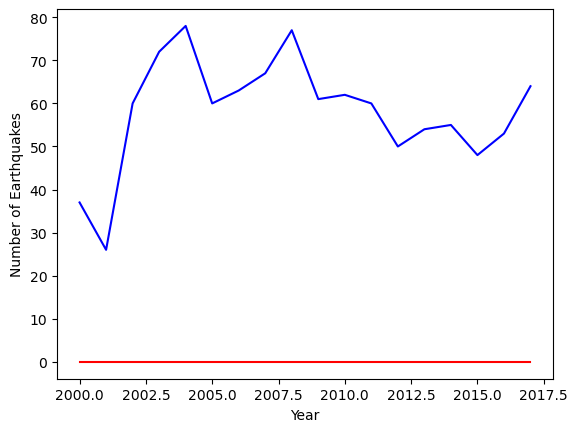

In [11]:
test(test_dataloader)